In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
from matplotlib.ticker import MaxNLocator

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

In [ ]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler.from_specs("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
data_handler = DataHandler.from_several_dhs(data_handlers)
exp = JetFindingExperiment(data_handler)
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df = exp.props_as_df(True)
jet_pos_da = jet_position_as_da(all_jets_one_df, exp.path)

In [ ]:
clu = Clusterplot(1, 1, get_region(jet_pos_da))
clu.fig.savefig(f"{FIGURES}/jet_detection_demo/region.png")

# New demo

In [3]:
ds = xr.open_mfdataset("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/flat_wind/dailymean/20221*.nc")
ds = compute(ds, progress_flag=True)
df_ds = pl.from_pandas(ds.to_dataframe().reset_index())

[########################################] | 100.00% Completed | 405.26 ms


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


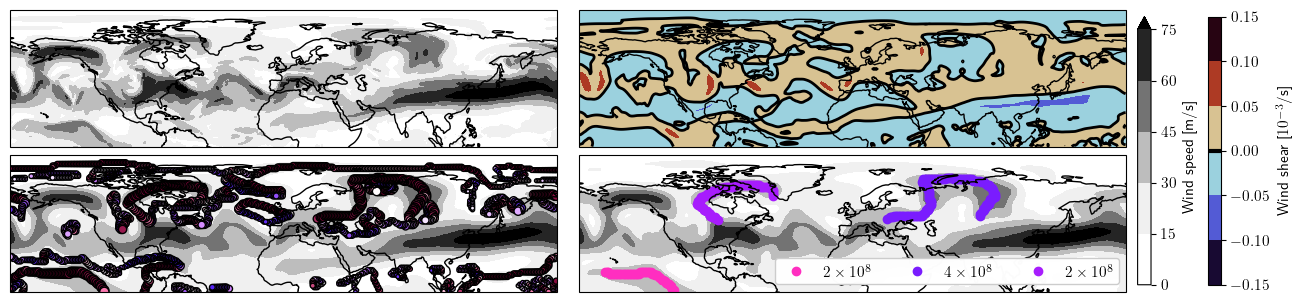

In [ ]:
times = df_ds["time"].unique().to_numpy()
# timestep = np.random.choice(len(times))
df = df_ds.filter(pl.col("time") == times[timestep])
df = df.filter(pl.col("lat").is_in([-90., 90.]).not_())
thresholds = xr.open_dataarray(
    "/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/results/s_q.nc"
).rename("s").sel(quantile=0.6)

clu = Clusterplot(2, 2, get_region(ds))
cmap1 = colormaps.greys
levels_wind = np.arange(0, 76, 15)
cmap1 = make_transparent(cmap1, len(levels_wind), 1, 1, 1)
norm1 = BoundaryNorm(levels_wind, cmap1.N, extend="max")
im1 = ScalarMappable(norm1, cmap1)
cmap2 = colormaps.fusion_r
levels_sigma = MaxNLocator(5, symmetric=True).tick_values(-.12, .12)
norm2 = BoundaryNorm(levels_sigma, cmap2.N, extend="neither")
im2 = ScalarMappable(norm2, cmap2)
cbar2 = clu.fig.colorbar(im2, ax=clu.axes, pad=0.01, shrink=0.95, spacing="proportional", label="Wind shear [$10^{-3}$/s]")
cbar2.ax.plot([0, 1], [0, 0], lw=3, color="black")
clu.fig.colorbar(im1, ax=clu.axes, pad=0.01, shrink=0.95, spacing="proportional", label="Wind speed [m/s]")
colors_jets = colormaps.bold(np.arange(20) % 10)

BLUEWHITERED = LinearSegmentedColormap.from_list("bluewhitered", [colormaps.cet_l_bmw(0.34)[:3], COLORS_EXT[0], "#ffffff", COLORS_EXT[9], COLORS_EXT[11]])

if thresholds is not None:
    thresholds = (
        pl.from_pandas(thresholds.to_dataframe().reset_index())
        .drop("quantile")
        .cast({"s": pl.Float32})
        .rename({"s": "s_thresh"})
    )
    df = df.join(thresholds, on="time")
    df = df.with_columns(int_thresh=pl.col("s_thresh") * 1.2e8 / 25)
    condition_expr = (pl.col("s") > pl.col("s_thresh")) & (pl.col("alignment") > 0.4)
    condition_expr2 = pl.col("int") > pl.col("int_thresh")
    drop = ["contour", "index", "cyclic", "s_thresh", "int_thresh"]
else:
    condition_expr = (pl.col("s") > 25) & (pl.col("alignment") > 0.4)
    condition_expr2 = pl.col("int") > 1.1e8
    drop = ["contour", "index", "cyclic", "s_thresh", "int_thresh"]
index_columns = get_index_columns(df)

lon = df["lon"].unique().sort().to_numpy()
lat = df["lat"].unique().sort().to_numpy()
to_plot_s = xr.DataArray(
    df["s"].to_numpy().reshape(len(lat), len(lon)), coords={"lat": lat, "lon": lon}
)
clu.axes[0].contourf(lon, lat, to_plot_s, cmap=cmap1, norm=norm1)

x_periodic = has_periodic_x(df)
df = coarsen(df, {"lon": 1, "lat": 1})
df = smooth_in_space(df, 7)
df = compute_sigma(df)

lon = df["lon"].unique().sort().to_numpy()
lat = df["lat"].unique().sort().to_numpy()
to_plot_s = xr.DataArray(
    df["s"].to_numpy().reshape(len(lat), len(lon)), coords={"lat": lat, "lon": lon}
)
to_plot_sigma = xr.DataArray(
    df["sigma"].to_numpy().reshape(len(lat), len(lon)), coords={"lat": lat, "lon": lon}
)
clu.axes[1].contourf(lon, lat, to_plot_sigma * 1000, cmap=cmap2, norm=norm2)
clu.axes[1].contour(lon, lat, to_plot_sigma * 1000, levels=0, linewidths=2, colors="black")
for i in [2, 3]:
    clu.axes[i].contourf(lon, lat, to_plot_s, cmap=cmap1, norm=norm1)
all_contours = compute_contours(df)
all_contours = all_contours.with_columns(
    index=all_contours.group_by([*index_columns, "contour"], maintain_order=True)
    .agg(index=pl.int_range(0, pl.col("lon").len()))
    .explode("index")["index"]
)
all_contours = all_contours.cast({"time": df["time"].dtype}).join(
    df, on=[*index_columns, "lon", "lat"], how="left"
)
all_contours = compute_alignment(all_contours)
for indexer, contour in all_contours.group_by([*index_columns, "contour"]):
    lo, la, s, al = contour[["lon", "lat", "s", "alignment"]].to_numpy().T
    clu.axes[2].scatter(
        lo,
        la,
        c=al,
        s=s,
        cmap=BLUEWHITERED,
        vmin=-1.,
        vmax=1.,
        edgecolors="black",
    )
conditional = do_rle_fill_hole(all_contours, condition_expr, 8)
jets = conditional.join(all_contours, on=[*index_columns, "contour", "index"])
jets = separate_jets(jets, 5)
jets = jets.with_columns(
    len=jets.group_by([*index_columns, "jet ID"], maintain_order=True)
    .agg(pl.col("jet ID").len().repeat_by(pl.col("jet ID").len()).alias("len"))[
        "len"
    ]
    .list.explode()
    .list.explode()
)
jets = jets.filter(pl.col("len") >= 5).drop("len")
jets = jets.with_columns(
    jets.group_by([*index_columns, "jet ID"], maintain_order=True)
    .agg(
        jet_integral_haversine(pl.col("lon"), pl.col("lat"), pl.col("s"))
        .alias("int")
        .repeat_by(pl.col("jet ID").len())
    )
    .explode("int")
    .explode("int")["int"]
)
i = 0
for indexer, jet in jets.group_by([*index_columns, "jet ID"], maintain_order=True):
    lo, la, int_, int_thresh = jet[["lon", "lat", "int", "int_thresh"]].to_numpy().T
    int_ = int_[0]
    int_thresh = int_thresh[0]
    if int_ < int_thresh:
        continue
    if len(lo) < 15:
        continue
    clu.axes[3].scatter(lo, la, color=COLORS[2 - i], label=f"${num2tex(int_)}$")
    i = i + 1
clu.axes[3].legend(ncol=3, framealpha=0.99)

jets = jets.filter(condition_expr2).drop(drop)
jets = jets.with_columns(
    **{
        "jet ID": jets.group_by(index_columns, maintain_order=True)
        .agg(pl.col("jet ID").rle_id().alias("id2"))
        .explode("id2")["id2"]
    }
)
# clu.fig.suptitle(f"{np.datetime_as_string(times[timestep], unit='m')}", fontsize=14)
clu.resize_relative([1., 0.9])
# plt.savefig(f"{FIGURES}/jet_detection_demo/new.png")

In [82]:
df = df.filter(pl.col("lat").is_in([-90., 90.]).not_())
index_columns = get_index_columns(df, ("member", "time", "cluster"))
periodic_x = has_periodic_x(df)
x = pl.col("lon").radians() * RADIUS
y = (
    (1 + pl.col("lat").radians().sin()) / pl.col("lat").radians().cos()
).log() * RADIUS
df = df.with_columns(x=x, y=y)
index_columns = get_index_columns(df)
diff_by = diff_maybe_periodic("x", True)
# directional_diff(df, "s", "x", periodic_x)
# df = df.join(directional_diff(df, "s", "y"), on=[*index_columns, "x", "y"])
# sigma = (pl.col("v") * pl.col("dsdx") - pl.col("u") * pl.col("dsdy")) / pl.col("s")
# df = df.with_columns(sigma=sigma)
# df = df.sort([*index_columns, "lat", "lon"])
# df = df.drop("x", "y", "dsdx", "dsdy")

In [84]:
diff_by

## as 4 figures

In [ ]:
from IPython.display import clear_output
times = df_ds["time"].unique().to_numpy()
timestep = np.random.choice(len(times))
df = df_ds.filter(pl.col("time") == times[timestep])
thresholds = xr.open_dataarray(
    "/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/results/s_q.nc"
).rename("s").sel(quantile=0.6)

cmap1 = colormaps.greys
levels_wind = np.arange(0, 76, 15)
cmap1 = make_transparent(cmap1, len(levels_wind), 1, 1, 1)
norm1 = BoundaryNorm(levels_wind, cmap1.N, extend="max")
im1 = ScalarMappable(norm1, cmap1)
cmap2 = colormaps.fusion_r
levels_sigma = MaxNLocator(5, symmetric=True).tick_values(-.12, .12)
norm2 = BoundaryNorm(levels_sigma, cmap2.N, extend="neither")
im2 = ScalarMappable(norm2, cmap2)
# cbar2 = clu.fig.colorbar(im2, ax=clu.axes, pad=0.01, shrink=0.95, spacing="proportional", label="Wind shear [$10^{-3}$/s]")
# cbar2.ax.plot([0, 1], [0, 0], lw=3, color="black")
# clu.fig.colorbar(im1, ax=clu.axes, pad=0.01, shrink=0.95, spacing="proportional", label="Wind speed [m/s]")
colors_jets = colormaps.bold(np.arange(20) % 10)

BLUEWHITERED = LinearSegmentedColormap.from_list("bluewhitered", [colormaps.cet_l_bmw(0.34)[:3], COLORS_EXT[0], "#ffffff", COLORS_EXT[9], COLORS_EXT[11]])

if thresholds is not None:
    thresholds = (
        pl.from_pandas(thresholds.to_dataframe().reset_index())
        .drop("quantile")
        .cast({"s": pl.Float32})
        .rename({"s": "s_thresh"})
    )
    df = df.join(thresholds, on="time")
    df = df.with_columns(int_thresh=pl.col("s_thresh") * 1.2e8 / 25)
    condition_expr = (pl.col("s") > pl.col("s_thresh")) & (pl.col("alignment") > 0.4)
    condition_expr2 = pl.col("int") > pl.col("int_thresh")
    drop = ["contour", "index", "cyclic", "s_thresh", "int_thresh"]
else:
    condition_expr = (pl.col("s") > 25) & (pl.col("alignment") > 0.4)
    condition_expr2 = pl.col("int") > 1.1e8
    drop = ["contour", "index", "cyclic", "s_thresh", "int_thresh"]
index_columns = get_index_columns(df)

lon = df["lon"].unique().sort().to_numpy()
lat = df["lat"].unique().sort().to_numpy()

clu = Clusterplot(1, 1, get_region(ds))
to_plot_s = xr.DataArray(
    df["s"].to_numpy().reshape(len(lat), len(lon)), coords={"lat": lat, "lon": lon}
)
clu.axes[0].contourf(lon, lat, to_plot_s, cmap=cmap1, norm=norm1)
plt.savefig(f"{FIGURES}/jet_detection_demo/new1.pdf")
del clu
clear_output()

df = coarsen(df, {"lon": 1, "lat": 1})
df = smooth_in_space(df, 7)
df = compute_sigma(df)
# df = smooth_in_space(df, , to_smooth="sigma")

lon = df["lon"].unique().sort().to_numpy()
lat = df["lat"].unique().sort().to_numpy()
to_plot_s = xr.DataArray(
    df["s"].to_numpy().reshape(len(lat), len(lon)), coords={"lat": lat, "lon": lon}
)
to_plot_sigma = xr.DataArray(
    df["sigma"].to_numpy().reshape(len(lat), len(lon)), coords={"lat": lat, "lon": lon}
)
clu = Clusterplot(1, 1, get_region(ds))
to_plot_s = xr.DataArray(
    df["s"].to_numpy().reshape(len(lat), len(lon)), coords={"lat": lat, "lon": lon}
)
clu.axes[0].contourf(lon, lat, to_plot_sigma * 1000, cmap=cmap2, norm=norm2)
clu.axes[0].contour(lon, lat, to_plot_sigma * 1000, levels=0, linewidths=2, colors="black")
plt.savefig(f"{FIGURES}/jet_detection_demo/new2.pdf")
del clu
clear_output()

all_contours = compute_contours(df)
all_contours = all_contours.with_columns(
    index=all_contours.group_by([*index_columns, "contour"], maintain_order=True)
    .agg(index=pl.int_range(0, pl.col("lon").len()))
    .explode("index")["index"]
)
all_contours = all_contours.cast({"time": df["time"].dtype}).join(
    df, on=[*index_columns, "lon", "lat"], how="left"
)
all_contours = compute_alignment(all_contours)

clu = Clusterplot(1, 1, get_region(ds))
clu.axes[0].contourf(lon, lat, to_plot_s, cmap=cmap1, norm=norm1)
for indexer, contour in all_contours.group_by([*index_columns, "contour"]):
    lo, la, s, al = contour[["lon", "lat", "s", "alignment"]].to_numpy().T
    clu.axes[0].scatter(
        lo,
        la,
        c=al,
        s=s,
        cmap=BLUEWHITERED,
        vmin=-1.,
        vmax=1.,
        edgecolors="black",
    )
plt.savefig(f"{FIGURES}/jet_detection_demo/new3.pdf")
del clu
clear_output()
conditional = do_rle_fill_hole(all_contours, condition_expr, 8)
jets = conditional.join(all_contours, on=[*index_columns, "contour", "index"])
jets = separate_jets(jets, 5)
jets = jets.with_columns(
    len=jets.group_by([*index_columns, "jet ID"], maintain_order=True)
    .agg(pl.col("jet ID").len().repeat_by(pl.col("jet ID").len()).alias("len"))[
        "len"
    ]
    .list.explode()
    .list.explode()
)
jets = jets.filter(pl.col("len") >= 5).drop("len")
jets = jets.with_columns(
    jets.group_by([*index_columns, "jet ID"], maintain_order=True)
    .agg(
        jet_integral_haversine(pl.col("lon"), pl.col("lat"), pl.col("s"))
        .alias("int")
        .repeat_by(pl.col("jet ID").len())
    )
    .explode("int")
    .explode("int")["int"]
)
clu = Clusterplot(1, 1, get_region(ds))
clu.axes[0].contourf(lon, lat, to_plot_s, cmap=cmap1, norm=norm1)
i = 0
for indexer, jet in jets.group_by([*index_columns, "jet ID"], maintain_order=True):
    lo, la, int_, int_thresh = jet[["lon", "lat", "int", "int_thresh"]].to_numpy().T
    int_ = int_[0]
    int_thresh = int_thresh[0]
    if int_ < int_thresh:
        continue
    if len(lo) < 15:
        continue
    clu.axes[0].scatter(lo, la, color=COLORS[2 - i], label=f"${num2tex(int_)}$")
    i = i + 1
clu.axes[0].legend(ncol=3, framealpha=0.99)
plt.savefig(f"{FIGURES}/jet_detection_demo/new4.pdf")
del clu
clear_output()
jets = jets.filter(condition_expr2).drop(drop)
jets = jets.with_columns(
    **{
        "jet ID": jets.group_by(index_columns, maintain_order=True)
        .agg(pl.col("jet ID").rle_id().alias("id2"))
        .explode("id2")["id2"]
    }
)

In [ ]:
f"{np.datetime_as_string(times[timestep], unit='h')}"

# New Width demo

In [ ]:
df = exp.find_jets().filter(pl.col("time").dt.month() == 1, pl.col("time").dt.year() == 1959)

In [ ]:
times = df["time"].unique().to_numpy()
timestep = np.random.choice(len(times))

In [ ]:
clu = Clusterplot(1, 2, get_region(exp.ds))
to_plot = exp.ds["s"].isel(time=timestep).load()
clu.add_contourf([to_plot, to_plot], cmap=colormaps.greys, levels=7)
jets = df.filter(pl.col("time") == times[timestep])
da = to_plot

dn = 1
ns_df = pl.Series("n", np.delete(np.arange(-12, 12 + dn, dn), 12)).to_frame()

# Expr theta
# dxds = pl.col("lon").diff()
# dyds = pl.col("lat").diff()
theta = pl.arctan2(pl.col("v"), pl.col("u")).interpolate("linear") + np.pi / 2

# Expr normals
normallon = pl.col("lon") + pl.col("theta").cos() * pl.col("n")
normallat = pl.col("lat") + pl.col("theta").sin() * pl.col("n")

# Expr half_width
below = pl.col("s_interp") <= pl.max_horizontal(pl.col("s") / 4 * 3, pl.lit(25))
stop_up = below.arg_max()
nlo_up = pl.col("normallon").gather(stop_up)
nla_up = pl.col("normallat").gather(stop_up)
half_width_up = haversine(nlo_up, nla_up, pl.col("lon").get(0), pl.col("lat").get(0)).cast(
    pl.Float32
)

stop_down = below.len() - below.reverse().arg_max() - 1
nlo_down = pl.col("normallon").gather(stop_down)
nla_down = pl.col("normallat").gather(stop_down)
half_width_down = haversine(nlo_down, nla_down, pl.col("lon").get(0), pl.col("lat").get(0)).cast(
    pl.Float32
)

half_width = pl.when(pl.col("side") == -1).then(pl.col("half_width_down")).otherwise(pl.col("half_width_up")).list.first()

index_columns = get_index_columns(jets, ("member", "time", "cluster"))
agg_out = {ic: pl.col(ic).first() for ic in [*index_columns, "lon", "lat", "s"]}

first_agg_out = agg_out | {"half_width_up": half_width_up, "half_width_down": half_width_down}
second_agg_out = agg_out | {"half_width": pl.col("half_width").sum()}
third_agg_out = agg_out | {
    "width": (pl.col("half_width") * pl.col("s")).sum() / pl.col("s").sum()
}

da_df = pl.from_pandas(da.to_dataframe().reset_index()).drop(index_columns)
jets = jets[[*index_columns, "jet ID", "lon", "lat", "u", "v", "s"]]

jets = jets.with_columns(
    jets.group_by("jet ID", maintain_order=True)
    .agg(theta=theta, index=pl.int_range(pl.len()))
    .explode(["index", "theta"])
)
jets = jets.join(ns_df, how="cross")

jets = jets.with_columns(normallon=normallon, normallat=normallat)
jets = jets[
    [
        *index_columns,
        "jet ID",
        "index",
        "lon",
        "lat",
        "s",
        "n",
        "normallon",
        "normallat",
    ]
]
jets = jets.filter(
    pl.col("normallon") >= da_df["lon"].min(),
    pl.col("normallon") <= da_df["lon"].max(),
    pl.col("normallat") >= da_df["lat"].min(),
    pl.col("normallat") <= da_df["lat"].max(),
)

jets = jets.with_columns(s_interp=interp_from_other(jets, da_df))
cmap = colormaps.cet_l_bmy
norm = BoundaryNorm(np.linspace(0, 1, 5), cmap.N)
for _, jet in jets.group_by("jet ID", maintain_order=True):
    nx, ny, s_int, s = jet[["normallon", "normallat", "s_interp", "s"]]
    clu.axes[0].scatter(nx, ny, c=s_int / s, cmap=cmap, norm=norm)
jets = jets.with_columns(side=pl.col("n").sign().cast(pl.Int8))

jets = jets.group_by(["jet ID", "index", "side"], maintain_order=True).agg(
    **first_agg_out
)

jets = jets.with_columns(half_width=half_width).drop(["half_width_up", "half_width_down", "side"])
jets = jets.group_by(["jet ID", "index"]).agg(**second_agg_out)

cmap = colormaps.cet_l_bmw
for _, jet in jets.group_by("jet ID", maintain_order=True):
    x, y, s, hw = jet[["lon", "lat", "s", "half_width"]]
    clu.axes[0].scatter(x, y, s=s, c=hw, vmin=5e5, vmax=2.5e6, cmap=cmap)

# Categorization demo

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, HDBSCAN, OPTICS, MeanShift


PINKPURPLE = LinearSegmentedColormap.from_list("pinkpurple", [COLORS[2], COLORS[1]])
plt.ion()

fig, axes = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)
feature_names = ["lon", "lat", "lev"]
for season, axs in zip(["MAM", "JJA", "SON", "DJF"], axes.T):
    axs[0].set_title(season)
    these_jets = extract_season_from_df(all_jets_one_df, season)
    for ax, feature_ind, letter in zip(axs, [(0, 1), (2, 1)], list("ab")):
        cmap = make_transparent(colormaps.gray_r, nlev=100, n_transparent=0, alpha_others=0.0)
        x = these_jets[feature_names[feature_ind[0]]]
        y = these_jets[feature_names[feature_ind[1]]]
        is_polar = these_jets["is_polar"]
        im1 = ax.hexbin(x, y, gridsize=25, cmap=cmap)

        cmap = make_transparent(PINKPURPLE, nlev=100, n_transparent=0, alpha_others=0.0)
        im2 = ax.hexbin(x, y, gridsize=25, cmap=cmap, C=is_polar, linewidths=0)

        plt.draw()

        offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
        offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
        mask12 = np.isin(offsets1, offsets2)
        mask21 = np.isin(offsets2, offsets1)
        newalpha = (im1.get_array() / im1.get_array().max() * 2)[mask12]
        im2.set_alpha(np.clip(newalpha, 0.02, 1))
        im2 = ax.add_collection(im2)
        plt.draw()

        try:
            ax.set_xlabel(PRETTIER_VARNAME[feature_names[feature_ind[0]]])
            ax.set_ylabel(PRETTIER_VARNAME[feature_names[feature_ind[1]]])
        except KeyError:
            ax.set_xlabel(feature_names[feature_ind[0]])
            ax.set_ylabel(feature_names[feature_ind[1]])
        if feature_names[feature_ind[0]] == "lev":
            ax.invert_xaxis()
        if feature_names[feature_ind[1]] == "lev":
            ax.invert_yaxis()
        ax.annotate(f"{letter})", (2.2, 4), xycoords='axes points', ha="left", va="baseline", fontweight="demi", fontsize=12, bbox={"boxstyle": "square, pad=0.1", "edgecolor": "none", "facecolor": "white"}, usetex=False)
plt.savefig(f"{FIGURES}/jet_props_misc/is_polar_gmix.png")

In [ ]:
plt.ion()
MYPURPLES = LinearSegmentedColormap.from_list("mypurples", ["#ffffff", COLORS_EXT[4], COLORS_EXT[5]])
MYPINKS = LinearSegmentedColormap.from_list("mypinks", ["#ffffff", COLORS_EXT[7], COLORS_EXT[8]])


to_plot_1 = []
to_plot_2 = []
for season in ["DJF", "MAM", "JJA", "SON"]:
    if season is not None:
        to_plot_1.append(jet_pos_da.sel(time=jet_pos_da.time.dt.season==season, is_polar=False).mean("time"))
        to_plot_2.append(jet_pos_da.sel(time=jet_pos_da.time.dt.season==season, is_polar=True).mean("time"))
    else:
        to_plot_1.append(jet_pos_da.sel(jet="subtropical").mean("time"))
        to_plot_2.append(jet_pos_da.sel(jet="polar").mean("time"))
    season = "all year" if season is None else season

In [ ]:
clu = Clusterplot(2, 2, get_region(jet_pos_da))
im, kwargs = clu.add_contourf([tp2 for tp2 in to_plot_2], transparify=0.7, levels=8, cmap=MYPURPLES, draw_cbar=False)
cbar = clu.fig.colorbar(im, ax=clu.axes, shrink=0.99, pad=0.01)
cbar.ax.set_ylabel("Eddy-driven jet occurence", fontsize=13)
im, kwargs = clu.add_contourf([tp1 for tp1 in to_plot_1], transparify=0.7, levels=7, cmap=MYPINKS, draw_cbar=False)
cbar = clu.fig.colorbar(im, ax=clu.axes, shrink=0.99, pad=0.01)
cbar.ax.set_ylabel("Subtropical jet occurence", fontsize=13)
for ax, season in zip(clu.axes, ["DJF", "MAM", "JJA", "SON"]):
    ax.annotate(season, (2.2, 5), xycoords='axes points', ha="left", va="baseline", fontweight="demi", fontsize=15, bbox={"boxstyle": "square, pad=0.1", "edgecolor": "none", "facecolor": "white"}, usetex=False)
clu.resize_relative([1.0, 0.89])
plt.savefig(f"{FIGURES}/jet_props_misc/is_polar_map.png")

# 2PVU surface sucks

In [ ]:
from jetstream_hugo.definitions import _compute
ds_2pvu = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/2PVU/raw/199707.nc")
minlon, maxlon, minlat, maxlat = -80, 40, 15, 80
ds_2pvu = standardize(ds_2pvu)
ds_2pvu = ds_2pvu.sel(lon=slice(minlon, maxlon), lat=slice(minlat, maxlat))
ds_2pvu["s"] = np.sqrt(ds_2pvu["u"] ** 2 + ds_2pvu["v"] ** 2)
da_2pvu = ds_2pvu["s"]
da_press = _compute(exp.ds["s"].sel(time=da_2pvu.time), progress=True)

In [ ]:
clu = Clusterplot(1, 2, get_region(da_2pvu))
it = 50
_ = clu.add_contourf([da_press.isel(time=it), da_2pvu.isel(time=it)], cmap=colormaps.matter, transparify=1, levels=7, titles=[da_press[it].time.values] * 2)
clu.fig.savefig(f"{FIGURES}/jet_detection_demo/2pvu_comp.png")

# jet detection demo + comparison with S17

In [ ]:
from dynlib.detect import jetaxis
from dynlib import dynfor
dynfor.config.jetint_thres = 1.e-11

In [ ]:
from itertools import pairwise


def haversine_np(lon1: NDArray, lat1: NDArray, lon2: NDArray, lat2: NDArray) -> NDArray:
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return RADIUS * c


def compute_dx_dy(ds):
    lon = ds.lon.values
    lat = ds.lat.values
    lon_ = lon[None, :] * np.ones(len(lat))[:, None]
    lat_ = lat[:, None] * np.ones(len(lon))[None, :]

    dx_forward = haversine_np(lon_[:, 1:], lat_[:, 1:], lon_[:, :-1], lat_[:, :-1])
    dx_backwards = haversine_np(lon_[:, :-1], lat_[:, :-1], lon_[:, 1:], lat_[:, 1:])

    dy_forward = haversine_np(lon_[1:, :], lat_[1:, :], lon_[:-1, :], lat_[:-1, :])
    dy_backwards = haversine_np(lon_[:-1, :], lat_[:-1, :], lon_[1:, :], lat_[1:, :])

    dx = np.zeros(ds["s"].shape[1:])
    dx[:, 0] = dx_backwards[:, 0]
    dx[:, -1] = dx_forward[:, -1]
    dx[:, 1:-1] = (dx_forward[:, :-1] + dx_backwards[:, 1:]) / 2

    dy = np.zeros(ds["s"].shape[1:])
    dy[0, :] = dy_backwards[0, :]
    dy[-1, :] = dy_forward[-1, :]
    dy[1:-1, :] = (dy_forward[:-1, :] + dy_backwards[1:, :]) / 2
    return dx, dy


def find_jets_spensberger(ds, no: int = 4000, nf: int = 100):
    ds = coarsen_da(ds, 1.5)
    dx, dy = compute_dx_dy(ds)
    lon_da = ds.lon.assign_coords(lon=("lon", np.arange(len(ds.lon))))
    lat_da = ds.lat.assign_coords(lat=("lat", np.arange(len(ds.lat))))
    u_smo = smooth(ds["u"], smooth_map={"lon+lat": ("fft", 0.2)})
    v_smo = smooth(ds["v"], smooth_map={"lon+lat": ("fft", 0.2)})
    all_points, all_group_ends = jetaxis(no, nf, u_smo.values, v_smo.values, dx, dy)
    jets = []
    for points, group_ends in zip(all_points, all_group_ends):
        end = np.argmax(group_ends[1:] == 0) + 1
        if end == 1:
            continue
        jets.append([])
        x, y, s = points.T
        x = lon_da.interp(lon=x, method="linear").values
        y = lat_da.interp(lat=y, method="linear").values
        group = np.asarray([x, y, s]).T
        for istart, iend in pairwise(group_ends[:end].astype(int)):
            jets[-1].append(pd.DataFrame(group[istart:iend], columns=["lon", "lat", "s"]))
    return all_jets_to_one_df(jets, time=ds.time.values)

In [ ]:
clu = Clusterplot(2, 2, get_region(ds))
# it = np.random.randint(0, ds.time.shape[0])
# ds_ = preprocess(ds.isel(time=it), smooth_s=0.2)
t = np.datetime64('1959-10-09T00:00:00.000000000')
ds_ = preprocess(ds.sel(time=t), smooth_s=0.2)
lon, lat = ds_.lon.values, ds_.lat.values
levels_wind = np.arange(0, 76, 15)
cmap1 = colormaps.cet_l_wyor
cmap1 = make_transparent(cmap1, len(levels_wind), 1, 1, 1)
norm1 = BoundaryNorm(levels_wind, cmap1.N, extend="max")
im1 = ScalarMappable(norm1, cmap1)
cmap2 = colormaps.fusion_r
levels_sigma = MaxNLocator(7, symmetric=True).tick_values(-0.1, 0.1)
norm2 = BoundaryNorm(levels_sigma, cmap2.N, extend="neither")
im2 = ScalarMappable(norm2, cmap2)
clu.fig.colorbar(im2, ax=clu.axes, pad=0.01, shrink=0.95, spacing="proportional", label="Wind shear [$10^{-3}$/s]")
clu.fig.colorbar(im1, ax=clu.axes, pad=0.01, shrink=0.95, spacing="proportional", label="Wind speed [m/s]")

ax = clu.axes[0]
ax.contourf(lon, lat, ds_["s"], cmap=cmap1, norm=norm1)

ax = clu.axes[1]
ax.contourf(lon, lat, ds_["sigma"] * 1000, cmap=cmap2, norm=norm2)

ax = clu.axes[2]
dx = (ds_.lon[1] - ds_.lon[0]).item()
contours, types = contour_generator(x=lon, y=lat, z=ds_["sigma"].values * 1000, line_type="SeparateCode", quad_as_tri=False).lines(0.)
ax.contourf(lon, lat, ds_["s"], cmap=cmap1, norm=norm1)
groups = []
for contour, types_ in zip(contours, types):
    if len(contour) < 15:
        continue
    group = interp_xy_ds(ds_, contour[::-1])
    group = compute_alignment(group)
    x, y, s, alignment = group.to_dataframe()[["lon", "lat", "s", "alignment"]].to_numpy().T
    ax.plot(x, y, lw=1.5, color="black", zorder=-10)
    ax.scatter(x, y, c=alignment, s=s, cmap=colormaps.BlWhRe, vmin=-1.5, vmax=1.5, edgecolors="black")
    
ax = clu.axes[3]
wind_threshold: float = 23
jet_threshold: float = 1.e8
alignment_threshold: float = 0.4
mean_alignment_threshold: float = 0.7
contours, types = contour_generator(x=lon, y=lat, z=ds_["sigma"].values * 1000, line_type="SeparateCode", quad_as_tri=False).lines(0.)
ax.contourf(lon, lat, ds_["s"], cmap=cmap1, norm=norm1)
groups = []
for contour, types_ in zip(contours, types):
    if len(contour) < 15:
        continue
    cyclic: bool = 79 in types_ # code for line closing 
    group = interp_xy_ds(ds_, contour[::-1])
    group = compute_alignment(group)
    mask = (group["alignment"] > alignment_threshold) & (group["s"].values > wind_threshold)
    mask = mask.values
    indicess = get_runs_fill_holes(mask, hole_size=5, cyclic=cyclic)
    for indices in indicess:
        indices = np.unique(indices)
        if len(indices) < 5:
            continue
        group_df = group.to_dataframe().drop(columns="time").iloc[indices] # remove time
        group_ = group_df[["lon", "lat"]].values.astype(np.float32)
        labels = AgglomerativeClustering(n_clusters=None, distance_threshold=dx * 1.9, linkage="single").fit(group_).labels_
        masks = labels_to_mask(labels)
        for mask in masks.T:
            groups.append(group_df.iloc[mask])
jets = []
for group_df in groups:
    bigjump = np.diff(group_df["lon"]) < -3 * dx
    if any(bigjump):
        here = np.where(bigjump)[0][0] + 1
        group_df = group_df.apply(np.roll, args=(-here,), raw=True)
    if "P" in group_df and any(group_df["P"] < 0):
        continue
    group_ = group_df[["lon", "lat", "s"]].values.astype(np.float32)
    jet_int = jet_integral_haversine(group_)
    mean_alignment = np.mean(group_df["alignment"].values)
    if jet_int > jet_threshold and mean_alignment > mean_alignment_threshold:
        jets.append(group_df)
for jet in jets:
    x, y, s, P, alignment = jet[["lon", "lat", "s", "lev", "alignment"]].to_numpy().T
    # im = ax.scatter(x, y, c=P, cmap=cmap, norm=norm)
    ax.plot(x, y, color=COLORS[1], lw=5)
    
jets_spensberger = all_jets_spensberger.loc[t]
for jid, jet in jets_spensberger.groupby(level=0):
    i = int(jid)
    ax.plot(*jet[["lon", "lat"]].to_numpy().T, color="cyan", linestyle="dashed", lw=3)
    
for ax, letter in zip(clu.axes, list("abcd")):
    ax.annotate(f"{letter})", (2.2, 5.1), xycoords='axes points', ha="left", va="baseline", fontweight="demi", fontsize=15, bbox={"boxstyle": "square, pad=0.1", "edgecolor": "none", "facecolor": "white"}, usetex=False)
clu.resize_relative([1.0, 0.875])
    
plt.savefig(f"{FIGURES}/jet_detection_demo/full.png")

# width demo

In [ ]:
all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets(processes=N_WORKERS, chunksize=100)
props_as_ds_uncat = exp.props_as_ds(False, processes=N_WORKERS, chunksize=100)
props_as_ds = exp.props_as_ds(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_ds_uncat)

In [ ]:
MYBLUES = LinearSegmentedColormap.from_list("myblues", ["#ebebeb", COLORS_EXT[2]])
MYPURPLES = LinearSegmentedColormap.from_list("mypurples", ["#ebebeb", COLORS_EXT[5]])
MYPINKS = LinearSegmentedColormap.from_list("mypinks", ["#ebebeb", COLORS_EXT[8]])
MYREDS = LinearSegmentedColormap.from_list("myreds", ["#ebebeb", COLORS_EXT[11]])
PINKPURPLE = LinearSegmentedColormap.from_list("pinkpurple", [COLORS[2], COLORS[1]])

In [ ]:
t = np.datetime64('1959-06-16T00:00:00.000000000')
are_polar = props_as_ds_uncat.is_polar.loc[t].values
da_ = ds["s"].loc[t]
clu = Clusterplot(1, 2, get_region(da_))
cmap = colormaps.greys_light
cmap.set_over("red")
clu.add_contourf([da_.copy(data=np.zeros(da_.shape)), da_], cmap=cmap, transparify=2, draw_cbar=True, cbar_kwargs={"pad": 0.01,  "shrink": 0.85, "label": "Wind speed [m/s]"})
axes = clu.axes
crit_func = lambda s_: max(s_ / 2, 25)
vmax_func = lambda s_: max(s_, 26)
cmap = colormaps.cet_l_bmw_r
norm = BoundaryNorm(np.arange(0, 2.11, .3), cmap.N)
im = ScalarMappable(norm, cmap)
plt.colorbar(im, ax=axes[1], shrink=0.85, pad=0.01, label="Width [$10^6$m]")
cmap2 = colormaps.matter
norm2 = BoundaryNorm(np.arange(0.5, 1.01, 0.1), cmap2.N)
im2 = ScalarMappable(norm2, cmap2)
plt.colorbar(im2, ax=axes[0], shrink=0.85, pad=0.01, label="Wind speed relative to peak")
marker = "o"
for (_, jet), is_polar in zip(all_jets_one_df.loc[t].groupby(level=0), are_polar):
    axes[0].plot(*jet[["lon", "lat"]].to_numpy().T, color=COLORS[2 - int(is_polar)], lw=2.4, ls="solid")
    axes[1].plot(*jet[["lon", "lat"]].to_numpy().T, color=COLORS[2 - int(is_polar)], lw=2.4, ls="solid")
    jet_ = jet.iloc[::5]
    lon, lat = da_.lon.values, da_.lat.values
    lo, la, s = jet_[["lon", "lat", "s"]].to_numpy().T
    dxds = np.gradient(lo)
    dyds = np.gradient(la)
    theta = np.arctan2(dyds, dxds)

    dn = 0.5
    t = np.arange(-10, 10 + dn, dn)
    half_length = len(t) // 2
    widths = np.zeros(len(jet_))
    for k in range(len(jet_)):
        normallons = np.cos(theta[k] + np.pi / 2) * t + lo[k]
        normallats = np.sin(theta[k] + np.pi / 2) * t + la[k]
        mask_valid = (normallons >= lon.min()) & (normallons <= lon.max()) & (normallats >= lat.min()) & (normallats <= lat.max())
        if all(mask_valid):
            slice_ = slice(half_length, 0, -1)
            normal_s = slice_1d(da_, {"lon": normallons[slice_], "lat": normallats[slice_]}).values
            normal_s = np.concatenate([normal_s, [0]])
            stop = np.argmax(normal_s <= crit_func(s[k]))
            try:
                endlo = normallons[slice_][stop]
                endla = normallats[slice_][stop]
            except IndexError:
                endlo = normallons[slice_][-1]
                endla = normallats[slice_][-1]
                stop = stop - 1
            axes[0].scatter(normallons[slice_][:stop], normallats[slice_][:stop], c=normal_s[:stop], cmap=cmap2, vmin=crit_func(s[k]), vmax=vmax_func(s[k]), marker=marker, zorder=100)
            halfw1 = haversine(lo[k], la[k], endlo, endla)
            
            slice_ = slice(half_length + 1, len(t))
            normal_s = slice_1d(da_, {"lon": normallons[slice_], "lat": normallats[slice_]}).values
            normal_s = np.concatenate([normal_s, [0]])
            stop = np.argmax(normal_s <= crit_func(s[k]))
            try:
                endlo = normallons[slice_][stop]
                endla = normallats[slice_][stop]
            except IndexError:
                endlo = normallons[slice_][-1]
                endla = normallats[slice_][-1]
                stop = stop - 1
            axes[0].scatter(normallons[slice_][:stop], normallats[slice_][:stop], c=normal_s[:stop], cmap=cmap2, vmin=crit_func(s[k]), vmax=vmax_func(s[k]), marker=marker, zorder=100)
            halfw2 = haversine(lo[k], la[k], endlo, endla)
            widths[k] = 2 * min(halfw1, halfw2)
        elif np.mean(mask_valid[:half_length]) > np.mean(mask_valid[half_length + 1:]):
            slice_ = slice(half_length, 0, -1)
            normal_s = slice_1d(da_, {"lon": normallons[slice_], "lat": normallats[slice_]}).values
            normal_s = np.concatenate([normal_s, [0]])
            stop = np.argmax(normal_s <= crit_func(s[k]))
            try:
                endlo = normallons[slice_][stop]
                endla = normallats[slice_][stop]
            except IndexError:
                endlo = normallons[slice_][-1]
                endla = normallats[slice_][-1]
                stop = stop - 1
            axes[0].scatter(normallons[slice_][:stop], normallats[slice_][:stop], c=normal_s[:stop], cmap=cmap2, vmin=crit_func(s[k]), vmax=vmax_func(s[k]), marker=marker, zorder=100)
            widths[k] = 2 * haversine(lo[k], la[k], endlo, endla)
        else:
            slice_ = slice(half_length + 1, -1)
            normal_s = slice_1d(da_, {"lon": normallons[slice_], "lat": normallats[slice_]}).values
            normal_s = np.concatenate([normal_s, [0]])
            stop = np.argmax(normal_s <= crit_func(s[k]))
            try:
                endlo = normallons[slice_][stop]
                endla = normallats[slice_][stop]
            except IndexError:
                endlo = normallons[slice_][-1]
                endla = normallats[slice_][-1]
            axes[0].scatter(normallons[slice_][:stop], normallats[slice_][:stop], c=normal_s[:stop], cmap=cmap2, vmin=crit_func(s[k]), vmax=vmax_func(s[k]), marker=marker, zorder=100)
            widths[k] = 2 * haversine(lo[k], la[k], endlo, endla)
    axes[1].scatter(*jet_[["lon", "lat"]].to_numpy().T, c=widths / 1e6, cmap=cmap, norm=norm, marker="s", lw=3, s=60, zorder=12)
    
plt.savefig(f"{FIGURES}/jet_detection_demo/width.png")

# Extreme climatology

In [ ]:
sparse_exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", np.arange(1960, 2022, 5).tolist(), None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350])

In [ ]:
ds = sparse_exp.ds.load()
q_clim = compute_clim(ds["s"].quantile(np.arange(0.6, 1, 0.05), ["lon", "lat"]), "dayofyear")
q_clim = smooth(q_clim, {"dayofyear": ("win", 61)}).load()
q_clim.to_netcdf(f"{DATADIR}/ERA5/plev/results/s_q_clim.nc")

In [ ]:
q_clim.isel(quantile=3).plot()

# Anim track demo

In [ ]:
from jetstream_hugo.jet_finding import _track_jets
these_jets = all_jets_one_df.filter(pl.col("time").dt.year() == 2020)
ajot_df, flags = _track_jets(these_jets)
# flags = flags.filter(pl.col("time").dt.year() == 2020)
da = exp.ds["s"].sel(time=exp.ds.time.dt.year == 2020).load()

time_index_df = (
    these_jets.select("time")
    .with_row_index()
    .unique("time", keep="first", maintain_order=True)
)["index"].to_numpy()

time_index_flags = (
    flags.select("time")
    .with_row_index()
    .unique("time", keep="first", maintain_order=True)
)["index"].to_numpy()

In [ ]:
from matplotlib.collections import LineCollection, PathCollection
from matplotlib.animation import FuncAnimation

clu = Clusterplot(1, 1, get_region(da))
fig = clu.fig
ax = clu.axes[0]
times = da.time.values
lon, lat = da.lon.values, da.lat.values
kwargs_contourf, _, _, _ = clu.setup_contourf(
    [da.isel(time=0)], transparify=3, q=0.9, levels=11,
)
cs = ax.contourf(
    lon, lat, da.isel(time=0).values, **kwargs_contourf
)
minflag = flags["flag"].min()
flags_ = flags.with_columns(pl.col("flag") - minflag)
maxflag = flags_["flag"].max()
nturns = 15
flag_colors = colormaps.BlAqGrYeOrReVi200(np.linspace(0, nturns, maxflag) % 1)
ec_options = np.asarray(["black", "white"])
offsets = []
ec = []
colors = []
sizes = []
for j, (_, jet) in enumerate(these_jets[:time_index_df[1]].group_by("jet ID", maintain_order=True)):
    lo, la, s, isp = jet[["lon", "lat", "s", "is_polar"]].to_numpy().T
    offsets.append(np.stack([lo, la]).T)
    ec.append(ec_options[isp.astype(int)])
    color = flag_colors[flags_[int(time_index_flags[0] + j), "flag"]]
    colors.append(np.repeat(np.atleast_2d(color), len(lo), axis=0))
    sizes.append(s)
    
offsets = np.concatenate(offsets, axis=0)
ec = np.concatenate(ec, axis=0)
colors = np.concatenate(colors, axis=0)
sizes = np.concatenate(sizes, axis=0)

scat = ax.scatter(*offsets.T, marker="h", c=colors, s=sizes, edgecolor=ec, zorder=200)

cbar = fig.colorbar(cs)

def animate(i):
    global lc
    global cs
    try:
        these_jets_ = these_jets[time_index_df[i]:time_index_df[i + 1]]
    except IndexError:
        try:
            these_jets_ = these_jets[time_index_df[i]:]
        except IndexError:
            return lc, cs
    cs.remove()
    offsets = []
    colors = []
    ec = []
    sizes = []
    for j, (_, jet) in enumerate(these_jets_.group_by("jet ID", maintain_order=True)):
        lo, la, s, isp = jet[["lon", "lat", "s", "is_polar"]].to_numpy().T
        offsets.append(np.stack([lo, la]).T)
        color = flag_colors[flags_[int(time_index_flags[i] + j), "flag"]]
        colors.append(np.repeat(np.atleast_2d(color), len(lo), axis=0))
        ec.append(ec_options[isp.astype(int)])
        sizes.append(s)
        
    offsets = np.concatenate(offsets, axis=0)
    colors = np.concatenate(colors, axis=0)
    ec = np.concatenate(ec, axis=0)
    sizes = np.concatenate(sizes, axis=0)
    
    scat.set_offsets(offsets)
    scat.set_color(colors)
    scat.set_edgecolor(ec)
    scat.set_sizes(sizes)
    
    cs = ax.contourf(
        lon, lat, da.isel(time=i).values, **kwargs_contourf
    )
    ax.set_title(da.time[i].dt.strftime("%d-%m-%YT%H:00").item())
    return lc, cs

start = 8 * 4 * 30
ani = FuncAnimation(fig, animate, frames=range(start, start + 80, 2))
ani.save(f"{FIGURES}/jet_anim.gif", dpi=150, fps=1)

# tracking explicit

In [ ]:
df = these_jets
index_columns = get_index_columns(df)
df = df.select([*index_columns, "lon", "lat", "is_polar"]).clone()
unique_times = (
    df.select("time")
    .with_row_index()
    .unique("time", keep="first", maintain_order=True)
)
time_index_df = unique_times["index"]
unique_times = unique_times["time"]
df = df.with_columns(df.select(pl.col(["lon", "lat"]).map_batches(round_half)))
guess_nflags = max(50, len(unique_times))
guess_len = 1000
all_jets_over_time = np.zeros(
    (guess_nflags, guess_len), dtype=[("time", "datetime64[ms]"), ("jet ID", "i2")]
)
all_jets_over_time[:] = (np.datetime64("NaT"), -1)
last_valid_index_rel = np.full(guess_nflags, fill_value=-1, dtype="int16")
last_valid_index_abs = np.full(guess_nflags, fill_value=-1, dtype="int16")

flags = df.group_by(["time", "jet ID"], maintain_order=True).first()
flags = flags.select([*index_columns]).clone()
flags = flags.insert_column(
    -1, pl.Series("flag", np.zeros(len(flags), dtype=np.uint32))
)
time_index_flags = (
    flags.select("time")
    .with_row_index()
    .unique("time", keep="first", maintain_order=True)["index"]
)
for last_flag, _ in df[: time_index_df[1]].group_by("jet ID", maintain_order=True):
    last_flag = last_flag[0]
    all_jets_over_time[last_flag, 0] = (unique_times[0], last_flag)
    last_valid_index_rel[last_flag] = 0
    last_valid_index_abs[last_flag] = 0
    flags[last_flag, "flag"] = last_flag
current = current_process()
if current.name == "MainProcess":
    iterator = (pbar := trange(1, len(unique_times), position=0, leave=True))
else:
    iterator = range(1, len(unique_times))
for it in iterator:
    # create working dataframes: current timestep, previous 4 timesteps
    last_time = (
        time_index_df[it + 1] if (it < (len(time_index_df) - 1)) else df.shape[0]
    )
    current_df = df[time_index_df[it] : last_time]

    t = unique_times[it]
    min_it = max(0, it - 10)
    previous_df = df[time_index_df[min_it]: time_index_df[it]]
    potential_flags = np.where((last_valid_index_abs >= (it - 4)) & (last_valid_index_abs >= 0))[0]
    potentials = all_jets_over_time[potential_flags, last_valid_index_rel[potential_flags]]

    # Cumbersome construction for pairwise operations in polars
    # 1. Put potential previous jets in one df

    potentials_df = pl.concat(
        [
            previous_df.filter(
                pl.col("time") == jtt_idx[0], pl.col("jet ID") == jtt_idx[1]
            )
            for jtt_idx in potentials
        ]
    )
        
    potentials_df_gb = potentials_df.group_by(
        ["jet ID", "time"], maintain_order=True
    )

    # 2. Turn into lists
    potentials_df = potentials_df_gb.agg(pl.col("lon"), pl.col("lat"), pl.col("is_polar").mean())
    current_df = current_df.group_by(["jet ID", "time"], maintain_order=True).agg(
        pl.col("lon"), pl.col("lat"), pl.col("is_polar").mean()
    )

    # 3. create expressions (see function)
    vert_dist, overlap = overlap_vert_dist_polars()

    # perform pairwise using cross-join
    result = potentials_df.join(current_df, how="cross").select(
        old_jet="jet ID",
        new_jet="jet ID_right",
        vert_dist=vert_dist,
        overlap=overlap,
    )

    n_old = potentials_df.shape[0]
    n_new = current_df.shape[0]
    dist_mat = result["vert_dist"].to_numpy().reshape(n_old, n_new)
    overlaps = result["overlap"].to_numpy().reshape(n_old, n_new)

    try:
        dist_mat[np.isnan(dist_mat)] = np.nanmax(dist_mat) + 1
    except ValueError:
        pass
    index_start_flags = time_index_flags[it]
    connected_mask = (overlaps > 0.4) & (dist_mat < 12)
    potentials_isp = potentials_df["is_polar"].to_numpy()
    current_isp = current_df["is_polar"].to_numpy()
    connected_mask = (np.abs(potentials_isp[:, None] - current_isp[None, :]) < 0.25) & connected_mask
    flagged = np.zeros(n_new, dtype=np.bool_)
    for i, jtt_idx in enumerate(potentials):
        js = np.argsort(dist_mat[i])
        for j in js:
            if not connected_mask[i, j]:
                break
            if flagged[j]:
                continue
            this_flag = potential_flags[i]
            last_valid_index_rel[this_flag] = last_valid_index_rel[this_flag] + 1
            last_valid_index_abs[this_flag] = it
            all_jets_over_time[this_flag, last_valid_index_rel[this_flag]] = (t, j)
            flagged[j] = True
            flags[int(index_start_flags + j), "flag"] = this_flag
            break
    pass
    for j in range(n_new):
        if not flagged[j]:
            last_flag += 1
            last_valid_index_rel[last_flag] = 0
            last_valid_index_abs[last_flag] = it
            all_jets_over_time[last_flag, 0] = (t, j)
            flags[int(index_start_flags + j), "flag"] = last_flag
            flagged[j] = True
    if current.name == "MainProcess":
        pbar.set_description(f"last_flag: {last_flag}")
    if it == 10:
        break
        
ajot_df = []
for j, ajot in enumerate(all_jets_over_time[: last_flag + 1]):
    times = ajot["time"]
    ajot = ajot[: np.argmax(np.isnat(times))]
    ajot = pl.DataFrame(ajot)
    ajot = ajot.insert_column(
        0, pl.Series("flag", np.full(len(ajot), j, dtype=np.uint32))
    )
    if "member" in index_columns:
        ajot = ajot.insert_column(
            0,
            pl.Series("member", np.full(len(ajot), df["member"][0], dtype=object)),
        )
    ajot_df.append(ajot)
ajot_df = pl.concat(ajot_df)

cmap = colormaps.bold
nturns = 10
colors_flags = cmap(np.linspace(0, nturns, flags["flag"].max() + 1) % 1)
clu = Clusterplot(1, 2, get_region(da))
_ = clu.add_contourf([da[it - 1], da[it]], cmap=colormaps.matter, levels=7, transparify=1)
for indexer, jet in potentials_df.explode("lon", "lat").group_by(index_columns, maintain_order=True):
    j = indexer[1]
    lo, la = jet[["lon", "lat"]].to_numpy().T
    flag = flags.filter(pl.col("time") == indexer[0])[j, "flag"]
    color = colors_flags[flag]
    clu.axes[0].scatter(lo, la, label=flag, color=color)
clu.axes[0].set_title(da.time[it - 1].to_numpy())
clu.axes[0].legend()

for indexer, jet in current_df.explode("lon", "lat").group_by(index_columns, maintain_order=True):
    j = indexer[1]
    lo, la = jet[["lon", "lat"]].to_numpy().T
    flag = flags[int(time_index_flags[it] + j), "flag"]
    color = colors_flags[flag]
    clu.axes[1].scatter(lo, la, label=flag, color=color)
clu.axes[1].set_title(da.time[it].to_numpy())
clu.axes[1].legend()